In [4]:
%%bash
docker run \
  --rm \
  --name omnisci_test \
  --ipc=host \
  -d --runtime=nvidia \
  -v $(readlink -f ..)/data:/data \
  -v $(readlink -f ..)/scripts:/src \
  -p 6273-6280:6273-6280 \
  omnisci/core-os-cuda:v5.2.1

f8e5ac0b806f7557148c476698900f9cde8103e593f316ba9d1fe34e0f9d7fdf


In [5]:
%%bash
docker exec omnisci_test /bin/bash -c \
    "cat /src/load_dataset.sql | /omnisci/bin/omnisql -p 'HyperInteractive' -t"

User admin connected to database omnisci
Result
Loaded: 1067371 recs, Rejected: 0 recs in 0.362000 secs
1 rows returned.
Execution time: 445 ms, Total time: 445 ms
User admin disconnected from database omnisci


In [6]:
%%bash
docker exec omnisci_test /bin/bash -c \
    "echo 'SELECT * FROM online_retail LIMIT 10;' | /omnisci/bin/omnisql -p 'HyperInteractive' -t"

User admin connected to database omnisci
Invoice|StockCode|Description|Quantity|InvoiceDate|Price|CustomerID|Country
491675|21484|CHICK GREY HOT WATER BOTTLE|1|2009-12-13 12:04:00|3.45|16710|United Kingdom
490899|21774|DECORATIVE CATS BATHROOM BOTTLE|12|2009-12-08 13:04:00|1.25|16732|United Kingdom
491675|22113|GREY HEART HOT WATER BOTTLE|1|2009-12-13 12:04:00|3.45|16710|United Kingdom
490899|21773|DECORATIVE ROSE BATHROOM BOTTLE|12|2009-12-08 13:04:00|1.25|16732|United Kingdom
491675|21479|WHITE SKULL HOT WATER BOTTLE|1|2009-12-13 12:04:00|3.75|16710|United Kingdom
490741|21872|GLAMOROUS  MUG|1|2009-12-07 17:56:00|3.43|NULL|United Kingdom
490899|72008|FROSTED BOX 9 WHITE T-LIGHT CANDLES|12|2009-12-08 13:04:00|0.42|16732|United Kingdom
491662|84406B|CREAM CUPID HEARTS COAT HANGER|1|2009-12-13 11:16:00|3.25|15169|United Kingdom
491675|21481|FAWN BLUE HOT WATER BOTTLE|2|2009-12-13 12:04:00|2.95|16710|United Kingdom
490741|21874|GIN AND TONIC MUG|3|2009-12-07 17:56:00|3.43|NULL|United Kin

In [16]:
from pymapd import connect
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
queries = [
    "SELECT Invoice, SUM(Price*Quantity) as invoice_sum FROM online_retail GROUP BY Invoice ORDER BY invoice_sum DESC", #druid 2.77s
    "SELECT Country, SUM(Price*Quantity) as country_sum FROM online_retail GROUP BY Country ORDER BY country_sum DESC", #druid 1.39s
    "SELECT StockCode, COUNT(*) as n_items FROM online_retail GROUP BY StockCode", #druid 13.94s
    "SELECT CustomerID, SUM(Price*Quantity) as customer_sum FROM online_retail GROUP BY CustomerID ORDER BY customer_sum DESC", #druid 2.55s
    "SELECT InvoiceDate, SUM(Price*Quantity) as price_sum FROM online_retail GROUP BY InvoiceDate  ORDER BY price_sum", #druid 2.81s
    "SELECT CustomerID, Price*Quantity as total_price FROM online_retail WHERE Quantity > 20 ORDER BY total_price DESC", #druid X
    "SELECT InvoiceDate, AVG(Price*Quantity) as avg_total FROM online_retail GROUP BY InvoiceDate", #druid 7.66s
]

execution_timings = {
    "druid": [2.77, 1.39, 13.94, 2.55, 2.81, 0, 7.66],
    "omnisci": []
}

In [9]:
con = connect(user="admin", password="HyperInteractive", host="localhost", dbname="omnisci")

In [12]:
for query in queries:
    start = time()
    pd.read_sql_query(query, con=con)  # <-un po' più veloce ma usa ipc (arrow)
    # df = con.select_ipc_gpu(query)  # <-analogo
    # result = list(con.execute(query))  #NO IPC
    end = time()

    total = end-start
    execution_timings["omnisci"].append(total)
    print("QUERY:\n{}\ntooks: {:.2f}s\n".format(query, total))

QUERY:
SELECT Invoice, SUM(Price*Quantity) as invoice_sum FROM online_retail GROUP BY Invoice ORDER BY invoice_sum DESC
tooks: 0.17s

QUERY:
SELECT Country, SUM(Price*Quantity) as country_sum FROM online_retail GROUP BY Country ORDER BY country_sum DESC
tooks: 0.02s

QUERY:
SELECT StockCode, COUNT(*) as n_items FROM online_retail GROUP BY StockCode
tooks: 0.02s

QUERY:
SELECT CustomerID, SUM(Price*Quantity) as customer_sum FROM online_retail GROUP BY CustomerID ORDER BY customer_sum DESC
tooks: 0.78s

QUERY:
SELECT InvoiceDate, SUM(Price*Quantity) as price_sum FROM online_retail GROUP BY InvoiceDate  ORDER BY price_sum
tooks: 0.14s

QUERY:
SELECT CustomerID, Price*Quantity as total_price FROM online_retail WHERE Quantity > 20 ORDER BY total_price DESC
tooks: 0.22s

QUERY:
SELECT InvoiceDate, AVG(Price*Quantity) as avg_total FROM online_retail GROUP BY InvoiceDate
tooks: 0.10s



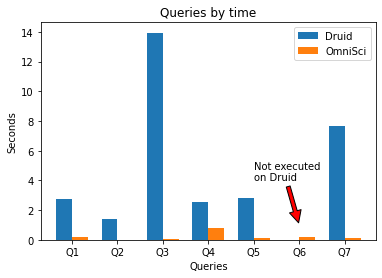

In [30]:
execution_timings

labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', ]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x - width/2, execution_timings["druid"], width, label='Druid')
ax.bar(x + width/2, execution_timings["omnisci"], width, label='OmniSci')

ax.set_title('Queries by time')
ax.set_xlabel('Queries')
ax.set_ylabel('Seconds')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.annotate('Not executed\non Druid', xy=(5, 1), xytext=(4, 4),
            arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

In [57]:
%%bash
docker stop omnisci_test

omnisci_test
